
#  オペレーティングシステム 演習 04
#  スケジューリング


名前と学生証番号を書け. Enter your name and student ID.

 * 名前 Name:
 * 学生証番号 Student ID:


# 1. スケジューリングの記録と可視化


* スレッド(プロセス)が脇目もふらず実行をしているつもりでも, そのようなスレッドが(仮想)コア数以上あれば, それらすべてのスレッドが, 同時に実行されているはずはない. 
* OSは, 時折スレッドをCPUコア上で切り替えながら実行しているはずである. その様子を観測する実験をしてみよう.


以下のプログラムは擬似コードで書けば以下のようなことをしている

```
 1: int main() {
 2:   t = 現在時刻();
 3:   while (10秒たつか記録する配列があふれるまで) {
 4:     t' = 現在時刻();
 5:     t'と, 最後に見た現在時刻(t)を比べる;
 6:     tとt'の差が非常に小さければ, 自分はtからt'までCPUが割り当てられていた,
 7:     そうでなければ, tからt'まで自分は走っていなかった
 8:     (CPUが他のスレッドに割り当てられていた)と考える;
 9:     t = t';
10:   }
11:   CPUが自分に割り当てられていたと考えられる時間帯を表示する;
12: }
```

* スレッドは実質的に時計を見る以外のことをせずにひたすら走り続けている
* したがってほんとんどの時, tとt'の差は小さいのだが稀に, そうでないことがある
* それはおそらくその間他のスレッドにCPUが割り当てられており自分はその時間帯OSによって止められていた場合に生ずる



* 以下が実際のCコード


In [ ]:
%%writefile sched_rec.c
#define _GNU_SOURCE
#include <assert.h>
#include <sched.h>
#include <sys/time.h>
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>


/* 時刻 begin -- end まで proc 上で動いていた記録 */
typedef struct {
  double begin;
  double end;
  int proc;
} rec_t;

/* 現在時刻を得る */
double cur_time() {
  struct timeval tp[1];
  gettimeofday(tp, 0);
  return tp->tv_sec + tp->tv_usec * 1.0E-6;
}

/* T秒間走り続け, CPUが割り当てられていたと思しき時間帯を記録する */
int run(double T, int n) {
  pid_t pid = getpid();
  double limit = cur_time() + T;
  rec_t * R = (rec_t *)calloc(n, sizeof(rec_t));
  int i = 0;
  R[i].begin = R[i].end = cur_time();
  R[i].proc = sched_getcpu();

  while (R[i].end < limit && i < n) {
    double t = cur_time(); /* 現在時刻を得る */
    int proc = sched_getcpu();
    if (t - R[i].end < 1.0E-3 && proc == R[i].proc) {
      /* 最後に見た時刻とあまり変わらない(< 1ms) -> R[i].endを増やす */
      R[i].end = t;
    } else {
      /* 最後に見た時刻から1ms以上たっている -> 新しい区間に入る */
      if (i + 1 >= n) break;
      i++;
      R[i].proc = proc;
      R[i].begin = R[i].end = cur_time();
    }
  }
  assert(i < n);
  int j;
  for (j = 0; j <= i; j++) {
    printf("%d %f %f %d %f\n", 
           pid, R[j].begin, R[j].end, R[j].proc,
           R[j].end - R[j].begin);
  }
  return 0;
}


int main(int argc, char ** argv) {
  double T = (argc > 1 ? atof(argv[1]) : 10.0);
  int n    = (argc > 2 ? atoi(argv[2]) : 100000);

  run(T, n);
  return 0;
}

In [ ]:
gcc -Wall -o sched_rec sched_rec.c


* 以下は1秒ほど, 単独で走らせてみる例
* 1行の読み方は以下
```
プロセスID  区間開始時刻  区間終了時刻  CPU番号 区間の長さ
```
* なお, Jupyterのbash kernelのバグによって出力が出ない場合があるかもしれない(経験上, 最初の一回がそうなることが多い). そういうときは何度か実行してみてください


In [ ]:
./sched_rec 1


* 各行はひとつの, 連続してOSにCPUを与えられていた時間(区間)を表している
* もし上記の結果が1行しか表示されなければそれは, 約1秒間, まったく(正確には1ms以上連続して)他のスレッドにCPUを奪われずに走っていたということになる(最後の行がほぼ1秒であることを確認せよ)
* 2行以上に渡った場合, ある区間の終了時刻と次の区間の開始時刻の差を観察してみよ(最後の行を合計するとほぼ1秒になることを確認せよ)



* 以下ではこのプロセスを複数同時に走らせると何が起きるかを観察, 可視化する
* その前に以下で, このJupyter環境(をホストしてるマシン)にいくつのCPU (正確には仮想コア)がつまれているかを見てみる


In [ ]:
lscpu


* 以下はシェルスクリプトで同時に4個, 3秒間このプロセスを走らせ, 結果はファイル sched.0, sched.1, sched.2, sched.3 に記録したもの


In [ ]:
./sched_rec 3 > sched.0 | ./sched_rec 3 > sched.1 | ./sched_rec 3 > sched.2 | ./sched_rec 3 > sched.3


# 2. スケジューリングの可視化
* sched_vis は sched_rec の結果を可視化する関数
* 同時に結果は sched.svg という画像ファイルに保存される


In [ ]:
#!/usr/bin/python3
import matplotlib.collections as mc
import matplotlib.pyplot as plt

def read_dats(files):
    sched = {}
    for f in files:
        with open(f) as fp:
            for line in fp:
                fields = line.strip().split()
                [ pid,a,b,proc,dt ] = fields
                pid = int(pid)
                a = float(a)
                b = float(b)
                proc = int(proc)
                if pid not in sched:
                    sched[pid] = []
                sched[pid].append((a, b, proc))
    return sched

def sched_vis(files, start_t=0, end_t=float("inf")):
    '''
    files : sched_rec の結果が入ったファイル名のリスト 
            (例: [ "rec.0", "rec.1", .. ])
    start_t, end_t : その中で可視化したい区間の開始と終了
            (結果の中の一番早い時点を0として指定. 例えば
             begin_t=1, end_t=3, は開始から1秒目〜3秒目の
             2秒間を可視化する)
    '''
    log = read_dats(files)
    T0 = min(min(a for a, _, _ in T)  for T in log.values())
    n_procs = max(max(p for _, _, p in T) for T in log.values()) + 1
    # cmap = plt.cm.get_cmap('RdYlGn', n_procs)
    cmap = plt.get_cmap('RdYlGn', n_procs)
    segs = []
    cols = []
    fig, ax = plt.subplots()
    for i,(pid,T) in enumerate(sorted(log.items())):
        T.sort()
        for a,b,proc in T:
            t0 = max(a - T0, start_t)
            t1 = min(b - T0, end_t)
            if t0 >= t1:
                continue
            rect = plt.Rectangle((a - T0, i), b - a, 1, fc=cmap(proc))
            ax.add_patch(rect)
    ax.autoscale()
    plt.title("thread scheduling")
    plt.xlabel("time")
    plt.ylabel("thread")
    plt.ylim(0, len(log))
    plt.savefig("sched.svg")
    plt.show()

* 以下で実際に可視化
* 以下は sched.0, sched.1, sched.2, sched.3 の4つのファイルを可視化する
* start_t, end_tを指定すれば可視化の開始時刻と終了時刻を指定できる(start_t=None, end_t=Noneにすると, それぞれファイル中に含まれる最小, 最大の時刻という意味)

In [ ]:
sched_vis(["sched.{}".format(i) for i in range(4)])
#sched_vis(["sched.{}".format(i) for i in range(4)], start_t=1.0, end_t=1.5)


* 本題は, プロセスをさらに増やしたらどうなるかということ
* 上記の書き方で複数同時に走らせるのはタイプ量の限界を超えるので, シェルスクリプトのループを使う
* 以下は8個のプロセスを3秒間走らせる
* 記録はsched.0 ... sched.7 に記録される

In [ ]:
for i in $(seq 0 7); do
  taskset -c 0-3 ./sched_rec 3 > sched.${i} &
done
wait


* <font color="blue">実行し終えたら再び, 可視化せよ</font>


In [ ]:
sched_vis(["sched.{}".format(i) for i in range(8)])
#sched_vis(["sched.{}".format(i) for i in range(8)], start_t=1.0, end_t=1.5)

* sched.svg というファイルが生成されているのでそれを開いて, 適宜拡大表示してみよ


* 上記の taskset コマンドはプロセスを特定のCPUでしか実行できないようにするコマンド(man参照)
```
taskset -c 0-3 ./sched_rec 3
```
はCPU 0 ... 3 を使えということ. <font color="blue">tasksetの引数を変えて結果の違いを観察せよ</font>
* プロセス数を 使うCPU数より少し少ないあたりから, 使うCPU数x2くらいまで, <font color="blue">色々変えて結果の違いを観察せよ</font>



* 注: 大勢で同じ環境を共有しているので, 複数の人が同時に同じ実験をすると自分は少数のプロセスしか立ち上げていなくても, 他の人のプロセスにCPUを奪われているかも知れない
* それ以外にもこのJupyterノートブック自身の処理やWebサーバの処理も行われるのでそれらにCPUを奪われることもある
* 従って, 同じ設定で実験しても結果は毎回同じとは限らない
* 自分だけの環境で走らせると結果の予測はしやすい


## 2-1. PythonでもCでも同じ
* プログラムがどの言語で書かれていてもOSがやることは同じであることを見せておく
* sched_rec.c と同じことをする Python プログラム


In [ ]:
%%writefile sched_rec.py
import os
import time
import sys

# Structure to store the time period and the CPU it ran on
class Rec:
    def __init__(self, begin, end, proc):
        self.begin = begin
        self.end = end
        self.proc = proc

# Get the current time
def cur_time():
    return time.time()

def get_current_cpu():
    with open("/proc/self/stat", "r") as f:
        stat = f.read().split()
        return int(stat[38])  # 39th field in /proc/self/stat is the CPU number

# Function that simulates continuous running for T seconds and records the CPU it ran on
def run(T, n):
    pid = os.getpid()  # Get process ID
    limit = cur_time() + T
    records = [Rec(cur_time(), cur_time(), get_current_cpu()) for _ in range(n)]
    i = 0
    records[i].begin = records[i].end = cur_time()

    while records[i].end < limit and i < n:
        t = cur_time()
        proc = get_current_cpu()  # Simulate sched_getcpu with affinity
        if t - records[i].end < 1.0E-3 and proc == records[i].proc:
            records[i].end = t
        else:
            if i + 1 >= n:
                break
            i += 1
            records[i].proc = proc
            records[i].begin = records[i].end = cur_time()
    assert i < n
    for j in range(i + 1):
        print(f'{pid} {records[j].begin:.6f} {records[j].end:.6f} {records[j].proc} {records[j].end - records[j].begin:.6f}')
    return 0

def main():
    # Get command line arguments
    T = float(sys.argv[1]) if len(sys.argv) > 1 else 10.0
    n = int(sys.argv[2]) if len(sys.argv) > 2 else 100000
    run(T, n)

if __name__ == "__main__":
    main()

* 上記と同様, 8 プロセスを4 仮想コア上で走らせる例

In [ ]:
for i in $(seq 0 7); do
  taskset -c 0-3 python3 sched_rec.py 3 > sched.${i} &
done
wait


* 可視化


In [ ]:
sched_vis(["sched.{}".format(i) for i in range(8)])
#sched_vis(["sched.{}".format(i) for i in range(8)], start_t=1.0, end_t=1.5)

# 3. Linux CFSスケジューラ


* OSによるスケジューリングの基本
  * 中断しているスレッドと実行可能なスレッドを区別する
  * 実行可能なスレッドに公平にCPU時間を割り当てる

* 公平にCPU時間を割り当てる方法は色々あるがLinux のデフォルトスケジューラである, Complete Fair Scheduler (CFS) はCPUの利用時間累計を記録して, スレッド切り替え(実行中スレッドが中断した, 中断中スレッドが復帰した, タイマ割り込みがおきたなど)のタイミングで, それが最も少ないものに割り当てるという自然なもの
* CFSではCPUの利用時間累計を, スレッドごとに vruntime という変数を割り当てて管理してる. すなわち使ったCPU時間だけvruntimeを加算し, 次に実行するスレッドを選ぶときにvruntime最小のスレッドにCPU時間を割り当てるのがCFSの基本である
* しかしvruntimeに文字通りのCPU利用時間累計を記録していくと, 生まれたばかりのスレッドはvruntime=0, また, ほとんどCPUを使わずにずっと中断していたスレッドも vruntime $\approx$ 0ということになり, それらのスレッドが急に計算を始めると, それらに長時間CPUが連続して割り当てられる(すでにCPUを10秒消費しているスレッドには10秒間順番がまわってこない)ということになりかねない
* したがってvruntimeは以下のような管理がなされる

1. 親スレッドAが子スレッドBを生成した時, BはAのvruntimeを引き継ぐ (プロセスの場合も同様)
   Bのvruntime = Aのvruntime
2. 実行中のスレッドAから別のスレッドBに実行が切り替わる(コンテクストスイッチ)時
   Aのvruntime += Aが今回消費した時間
3. 中断中のスレッドAが復帰する時
   Aのvruntime += max(Aのvruntime, min { tのvruntime | t : 実行可能なスレッド})



# 4. Vruntime の記録と可視化
* 以下のプログラムはvruntimeをずっと観測し続け, 時間とともにどう変化したかを記録する
* 以下が実際のCコード


In [ ]:
%%writefile vruntime_rec.c
#define _GNU_SOURCE
#include <assert.h>
#include <sched.h>
#include <time.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>

/* 時刻 begin -- end まで proc 上で動いていた記録 */
typedef struct {
  double begin;
  double end;
  double vruntime;
  int proc;
} rec_t;

/* 現在時刻を得る */
double cur_time() {
  struct timespec tp[1];
  clock_gettime(CLOCK_REALTIME, tp);
  return tp->tv_sec + tp->tv_nsec * 1.0e-9;
}


double cur_vruntime() {
  char buf[100];
  char field[100];
  double val;
  FILE * fp = fopen("/proc/self/sched", "rb");
  char * r;
  int x;
  r = fgets(buf, sizeof(buf), fp);
  assert(r);
  r = fgets(buf, sizeof(buf), fp);
  assert(r);
  assert(strcmp("-------------------------------------------------------------------\n",
		buf) == 0);
  fseek(fp, 68, SEEK_CUR);
  r = fgets(buf, sizeof(buf), fp);
  if (!r) {
    perror("fgets"); 
    fclose(fp);
    exit(1);
  }
  fclose(fp);
  //printf("%s", buf);
  x = sscanf(buf, "%s : %lf\n", field, &val);
  assert(x == 2);
  assert(strcmp(field, "se.vruntime") == 0);
  //printf("%s=%f\n", field, val);
  return val;
}

/* T秒間走り続け, vruntimeの変化を記録する */
int run(double T,
        long n) {
  pid_t pid = getpid();
  double limit = cur_time() + T;
  rec_t * R = (rec_t *)calloc(n, sizeof(rec_t));
  long i = 0;
  R[i].begin = R[i].end = cur_time();
  R[i].vruntime = cur_vruntime();
  R[i].proc = sched_getcpu();
  while (R[i].end < limit && i < n) {
    double t = cur_time(); /* 現在時刻を得る */
    double vr = cur_vruntime();
    int proc = sched_getcpu();
    if (vr == R[i].vruntime && proc == R[i].proc) {
      /* 最後に見たvruntimeと変化なし */
      R[i].end = t;
      R[i].vruntime = vr;
    } else {
      /* vruntimeが変化している -> 新しい区間に入る */
      if (i + 1 >= n) break;
      i++;
      R[i].proc = proc;
      R[i].begin = R[i].end = cur_time();
      R[i].vruntime = cur_vruntime();
    }
  }
  assert(i < n);
  int j;
  for (j = 0; j <= i; j++) {
    printf("%d %d %f %f %f %f\n", 
	   pid, R[j].proc,
           R[j].begin, R[j].end, R[j].end - R[j].begin,
           R[j].vruntime);
  }
  return 0;
}

int main(int argc, char ** argv) {
  long i = 1;
  double T     = (argc > i ? atof(argv[i]) : 10.0);    i++; /* 合計時間 */
  long n       = (argc > i ? atoi(argv[i]) : 1000000); i++;
  run(T, n);
  return 0;
}

In [ ]:
gcc -Wall -o vruntime_rec vruntime_rec.c


* 以下は1秒ほど, 単独で走らせてみて, 出力の最初の10行を表示する例
* 出力1行の読み方は以下
```
プロセスID CPU番号 区間開始時刻  区間終了時刻  区間の長さ その間のvruntime
```
* 各行は, vruntimeが変わらなかった区間を表している


In [ ]:
taskset -c 2 ./vruntime_rec 3 > vr.0
head vr.0


* なお以下の taskset -c 2 は processor (仮想コア) 2番 だけで実行せよという指示
* これはそのスレッドが1つの仮想コアでしか実行されないようにするための仕掛け(2番であることには意味はない)
* vruntime はprocessorごとに別々に管理されているため, スレッドがprocessor間を移動するとvruntimeは急に変化する(それはそれで見ておくと良い)



# 5. Vruntimeの可視化
* 以下が結果を可視化するプログラム


In [25]:
#!/usr/bin/python3
import sys
import re
import matplotlib.collections as mc
import matplotlib.pyplot as plt
import numpy as np

def read_dat(dat):
    pat = re.compile(r"(?P<pid>\d+) (?P<cpu>\d+) (?P<begin>\d+\.\d+) (?P<end>\d+\.\d+) (?P<dt>\d+\.\d+) (?P<vruntime>\d+)")
    log = {}
    with open(dat) as fp:
        for line in fp:
            m = pat.match(line)
            if not m:
                sys.stderr.write("warning: ignore line [%s]\n" % line.rstrip())
                continue
            pid = int(m.group("pid"))
            cpu = int(m.group("cpu"))
            begin = float(m.group("begin"))
            end = float(m.group("end"))
            dt = float(m.group("dt"))
            vruntime = int(m.group("vruntime"))
            if pid not in log:
                log[pid] = []
            log[pid].append((begin, end, vruntime, cpu))
    return log

def read_dats(dats):
    log = {}
    for dat in dats:
        log.update(read_dat(dat))
    return log

def vruntime_vis(files, start_t=0, end_t=float("inf")):
    log = read_dats(files)
    n_procs = len(log)
    n_cpus = max(max(cpu for _, _, _, cpu in recs) for recs in log.values()) + 1
    #cmap = plt.cm.get_cmap('RdYlGn', n_procs)
    cmap = plt.get_cmap('RdYlGn', n_procs)
    T0 = min(min(begin for begin, _, _, _ in recs) for recs in log.values())
    V0 = min(min(vrunt for _, _, vrunt, _ in recs) for recs in log.values())
    segs = []
    cols = []
    fig, ax = plt.subplots()
    for i, (pid, recs) in enumerate(log.items()):
        recs.sort()
        for begin, end, vruntime, cpu in recs:
            t0 = max(begin - T0, start_t)
            t1 = min(end - T0, end_t)
            if t0 >= t1:
                continue
            c = cmap(i)
            segs.append([(t0, vruntime), (t1, vruntime)])
            cols.append(c)
    wc = mc.LineCollection(segs, colors=cols, linewidths=3)
    ax.add_collection(wc)
    ax.autoscale()
    plt.title("thread vruntime")
    plt.xlabel("time")
    plt.ylabel("vruntime")
    plt.savefig("vruntime.svg")
    plt.show()
    
# usage:
# if you have n processes
# vruntime_vis(["vr.{}".format(i) for i in range(n)])


* 以下で実際に可視化


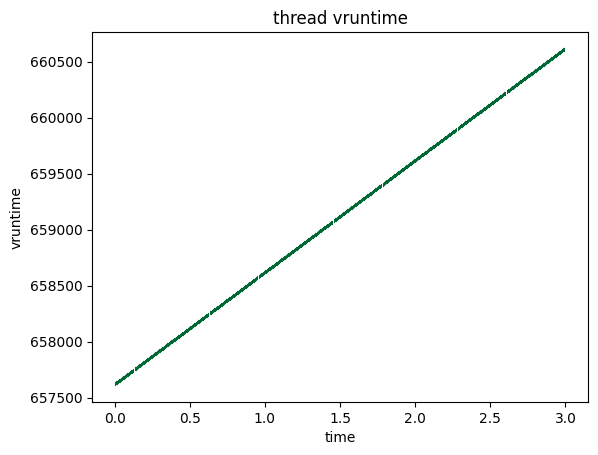

In [26]:
vruntime_vis(["vr.0"])

* 特定の領域を可視化するには, `start_t=開始時刻, end_t=終了時刻` を与える
* 一見して連続的に変化しているように見えるが, 狭い範囲をどんどん拡大してみると, 区間ごとに一定で, それが定期的に, 階段状に増加していることがわかる
* 以下の引数を変更して小さな区間を拡大表示してみよ

* 下記を実行するとvruntime.svgというSVG (ベクタ画像)ファイルが生成されるので, ある程度まで拡大表示した画像をダウンロードして適当な画像ビューアで拡大しても良い


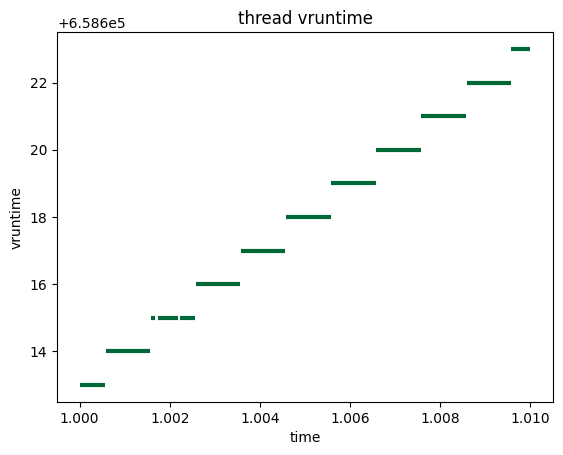

In [29]:
vruntime_vis(["vr.0"], start_t=1.0, end_t=1.01)

# 6. taskset でスレッドをprocessorに固定しない場合
* taskset でスレッドを特定のprocessorに固定しない場合, スレッドがprocessor間を動き回れるようになる
* 実際にスレッドがprocessor間を移動するかはわからないが, 途中でvruntime値が大きくジャンプしたらそれはおそらくprocessor (仮想コア)間をスレッドが移動したとき


In [30]:
./vruntime_rec 3 > vr.0

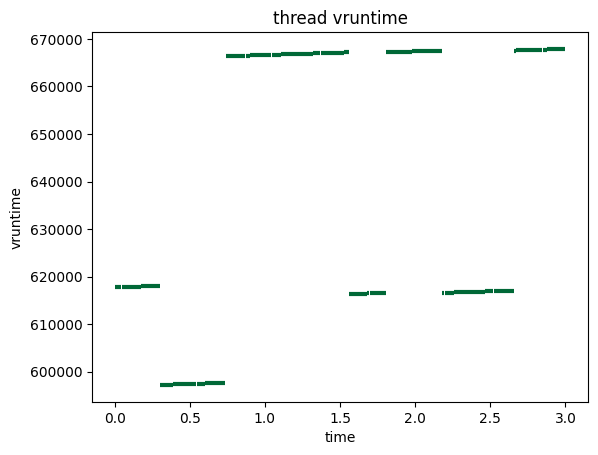

In [31]:
vruntime_vis(["vr.0"])
# vruntime_vis(["vr.0"], start_t=1.0, end_t=1.5)


# 7. 複数のスレッドがいる場合
* 以下はシェルスクリプトで同時に4個, 3秒間このプロセスを走らせ, 結果はファイル vr.0, vr.1, vr.2, vr.3 に記録したもの
* tasksetコマンドですべて同じprocessor (仮想コア) で実行するようにしている


In [32]:
for i in $(seq 0 3); do
  taskset -c 2 ./vruntime_rec 3 > vr.${i} &
done
wait

[1] 78131
[2] 78132
[3] 78133
[4] 78134
[1]   Done                    taskset -c 2 ./vruntime_rec 3 > vr.${i}
[2]   Done                    taskset -c 2 ./vruntime_rec 3 > vr.${i}
[3]-  Done                    taskset -c 2 ./vruntime_rec 3 > vr.${i}
[4]+  Done                    taskset -c 2 ./vruntime_rec 3 > vr.${i}



* 実行し終えたら再び可視化せよ
* 適切に短い区間を拡大表示するなどして4つのプロセスのvruntimeがどのように増えていくかを観察せよ


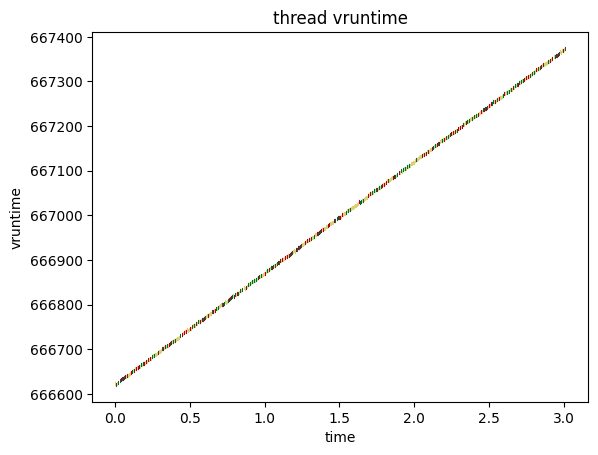

In [33]:
vruntime_vis(["vr.0", "vr.1", "vr.2", "vr.3"])
#vruntime_vis(["vr.0", "vr.1", "vr.2", "vr.3"], start_t=1.0, end_t=1.5)

* なお, プロセス数が多いときにも通用するもう少しスマートな書き方は以下 (これは純粋にPythonの話)

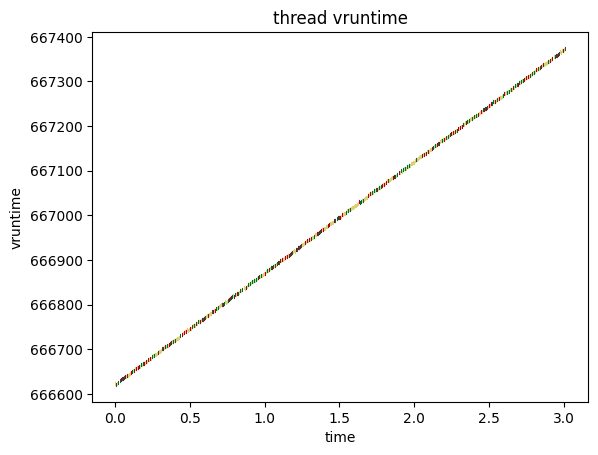

In [34]:
vruntime_vis([f"vr.{i}" for i in range(4)])
#vruntime_vis([f"vr.{i}" for i in range(4)], start_t=1.0, end_t=1.5)


# 8. Blockしている間はvruntimeは増えない
* 「vruntimeはCPUを使っていない時間は増えない」ことを確かめるために, 先のプログラムを少し走っては少し休むように変更したものが以下

```
./vruntime_rec_slp T R S
```

とすると, 「R秒走ってS秒sleepする」を, 合計T秒間繰り返す


In [35]:
%%writefile vruntime_rec_slp.c
#define _GNU_SOURCE
#include <assert.h>
#include <sched.h>
#include <time.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>

/* 時刻 begin -- end まで proc 上で動いていた記録 */
typedef struct {
  double begin;
  double end;
  double vruntime;
  int proc;
} rec_t;

/* 現在時刻を得る */
double cur_time() {
  struct timespec tp[1];
  clock_gettime(CLOCK_REALTIME, tp);
  return tp->tv_sec + tp->tv_nsec * 1.0e-9;
}

void sleep_sec(double slp_t) {
  struct timespec tp[1];
  tp->tv_sec = (long)slp_t;
  tp->tv_nsec = (slp_t - (long)slp_t) * 1.0e9;
  nanosleep(tp, 0);
}

double cur_vruntime() {
  char buf[100];
  char field[100];
  double val;
  FILE * fp = fopen("/proc/self/sched", "rb");
  char * r;
  int x;
  r = fgets(buf, sizeof(buf), fp);
  assert(r);
  r = fgets(buf, sizeof(buf), fp);
  assert(r);
  assert(strcmp("-------------------------------------------------------------------\n",
		buf) == 0);
  fseek(fp, 68, SEEK_CUR);
  r = fgets(buf, sizeof(buf), fp);
  if (!r) {
    perror("fgets"); 
    fclose(fp);
    exit(1);
  }
  fclose(fp);
  //printf("%s", buf);
  x = sscanf(buf, "%s : %lf\n", field, &val);
  assert(x == 2);
  assert(strcmp(field, "se.vruntime") == 0);
  //printf("%s=%f\n", field, val);
  return val;
}

/* T秒間走り続け, vruntimeの変化を記録する */
int run(double T,
        double run_t, double slp_t,
        long n) {
  pid_t pid = getpid();
  double limit = cur_time() + T;
  rec_t * R = (rec_t *)calloc(n, sizeof(rec_t));
  long i = 0;
  sleep_sec(slp_t);
  double start = R[i].begin = R[i].end = cur_time();
  R[i].vruntime = cur_vruntime();
  R[i].proc = sched_getcpu();
  while (R[i].end < limit && i < n) {
    double t = cur_time(); /* 現在時刻を得る */
    double vr = cur_vruntime();
    int proc = sched_getcpu();
    if (vr == R[i].vruntime && proc == R[i].proc) {
      /* 最後に見たvruntimeと変化なし */
      R[i].end = t;
      R[i].vruntime = vr;
    } else {
      /* vruntimeが変化している -> 新しい区間に入る */
      if (i + 1 >= n) break;
      i++;
      R[i].proc = proc;
      R[i].begin = R[i].end = cur_time();
      R[i].vruntime = cur_vruntime();
    }
    if (t > start + run_t) {
      sleep_sec(slp_t);
      start = cur_time();
    }
  }
  assert(i < n);
  int j;
  for (j = 0; j <= i; j++) {
    printf("%d %d %f %f %f %f\n", 
	   pid, R[j].proc,
           R[j].begin, R[j].end, R[j].end - R[j].begin,
           R[j].vruntime);
  }
  return 0;
}

int main(int argc, char ** argv) {
  long i = 1;
  double T     = (argc > i ? atof(argv[i]) : 10.0);    i++; /* 合計時間 */
  double run_t = (argc > i ? atof(argv[i]) : T);       i++; /* 1回走り続ける時間 */
  double slp_t = (argc > i ? atof(argv[i]) : 0);       i++; /* 1回sleepする時間 */
  long n       = (argc > i ? atoi(argv[i]) : 1000000); i++;
  run(T, run_t, slp_t, n);
  return 0;
}

Writing vruntime_rec_slp.c


In [36]:
gcc -Wall -o vruntime_rec_slp vruntime_rec_slp.c

* 実行

In [37]:
taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1 > vr.0

* vruntime可視化

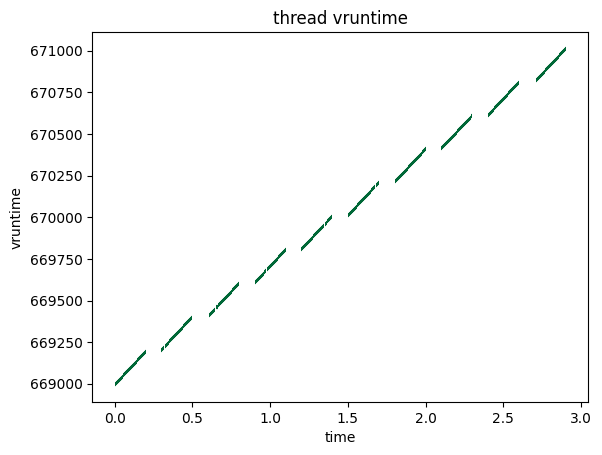

In [38]:
vruntime_vis(["vr.0"])
#vruntime_vis(["vr.0"], start_t=1.0, end_t=1.5)


* ずっとCPUを使っているスレッドの傍ら, 少し走っては少しsleepを繰り返すスレッドがいた場合, 後者がsleepから目覚めたときのvruntimeには何が起きているか
* 以下は
  * 0.2秒走って0.1秒sleep する (./vruntime_rec_slp 3 0.2 0.1) を1つと
  * ずっと走る (./vruntime_rec_slp 3 3 0) を3つ
同時に走らせる


In [39]:
for i in $(seq 0 3); do
  if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1 ;
  else
    taskset -c 2 ./vruntime_rec_slp 3 3 0 ;
  fi > vr.${i} &
done
wait

[1] 78172
[2] 78173
[3] 78174
[4] 78176
[1]   Done                    if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1;
else
    taskset -c 2 ./vruntime_rec_slp 3 3 0;
fi > vr.${i}
[3]-  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1;
else
    taskset -c 2 ./vruntime_rec_slp 3 3 0;
fi > vr.${i}
[2]-  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1;
else
    taskset -c 2 ./vruntime_rec_slp 3 3 0;
fi > vr.${i}
[4]+  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1;
else
    taskset -c 2 ./vruntime_rec_slp 3 3 0;
fi > vr.${i}


* 可視化

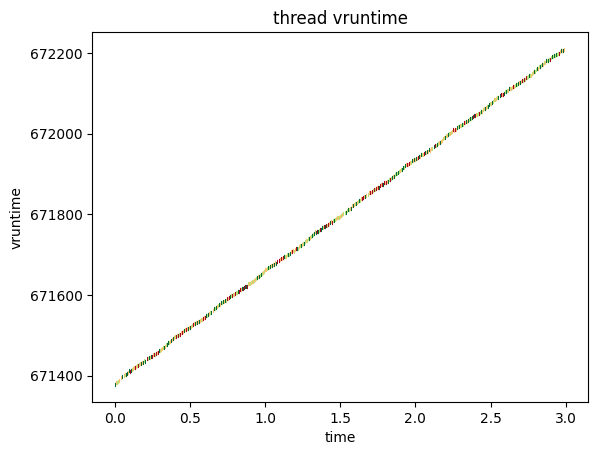

In [40]:
vruntime_vis([f"vr.{i}" for i in range(4)])
#vruntime_vis([f"vr.{i}" for i in range(4)], start_t=1.0, end_t=1.5)

# 9. niceの効果
* niceというコマンドならびにシステムコールがある
* プロセスの「nice値」を決めるもので, nice値が高い = 他のプロセスに実行をよく譲る(だからnice) = 優先度を非掬するというもの

```
nice -19 コマンド
```

は「コマンド」の「nice値」を19 (最大)にする. 同名のシステムコールもある.

* デフォルトのnice値は0. 正の値は多少なりとも優先度を下げるという意味になる

* nice値大きいプロセスと普通のプロセスが並走すると, ほとんどの時間を後者が消費するようになる

* CFSスケジューラでniceがどのように実現されているのかをvruntimeを観測することで考えてみよ

In [41]:
for i in $(seq 0 3); do
  if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3 ;
  else
    taskset -c 2 ./vruntime_rec 3 ;
  fi > vr.${i} &
done
wait

[1] 78191
[2] 78192
[3] 78193
[4] 78195
[1]   Done                    if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3;
else
    taskset -c 2 ./vruntime_rec 3;
fi > vr.${i}
[2]   Done                    if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3;
else
    taskset -c 2 ./vruntime_rec 3;
fi > vr.${i}
[3]-  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3;
else
    taskset -c 2 ./vruntime_rec 3;
fi > vr.${i}
[4]+  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3;
else
    taskset -c 2 ./vruntime_rec 3;
fi > vr.${i}


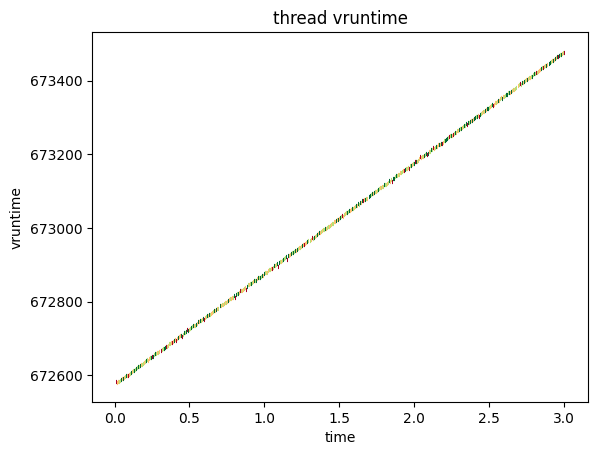

In [42]:
vruntime_vis([f"vr.{i}" for i in range(4)])
#vruntime_vis([f"vr.{i}" for i in range(4)], start_t=1.0, end_t=1.5)